In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, BatchNormalization, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [15]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
data_dir = '../dataset/oct/OCT2017/train/'

In [17]:
import os
from PIL import Image

image_dir = data_dir

for root, _, files in os.walk(image_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()  # Verify that the image can be opened
        except (IOError, SyntaxError):
            print(f"Removing corrupted image: {file_path}")
            os.remove(file_path)

In [18]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    height_shift_range=0.2,
    width_shift_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    validation_split=0.1,
    fill_mode='nearest'
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

In [19]:
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(160,160),
    class_mode='binary',
    subset = 'training',
    shuffle=True,
    batch_size=32
)
val_data = val_datagen.flow_from_directory(
    data_dir,
    target_size=(160,160),
    class_mode='binary',
    subset = 'validation',
    shuffle=False,
    batch_size=32
)

Found 12037 images belonging to 2 classes.
Found 1336 images belonging to 2 classes.


In [20]:
import os
Labels = os.listdir(data_dir)
Labels

['DME', 'NORMAL']

In [21]:
def view_images(data):
    images,labels = next(data)
    plt.figure(figsize=(12,12))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(images[i])
        plt.title('DME' if labels[i]==0 else 'NORMAL')
        plt.axis('off')
    plt.show()

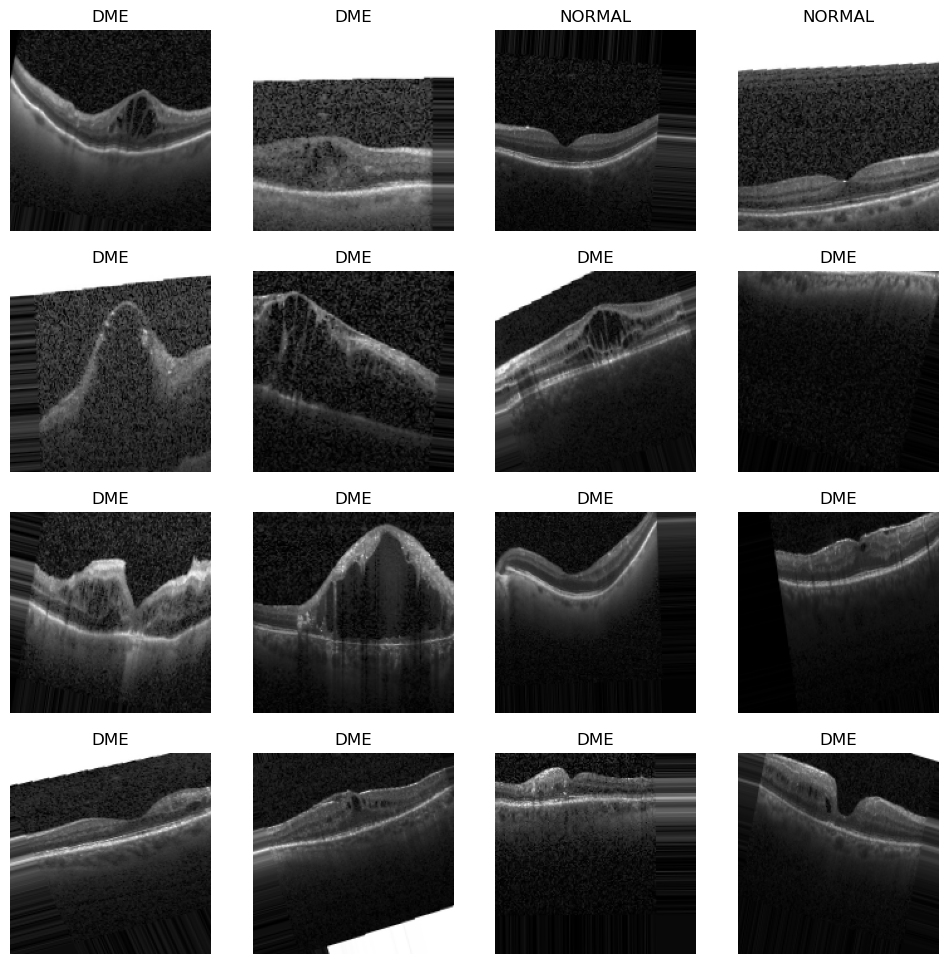

In [22]:
view_images(train_data)

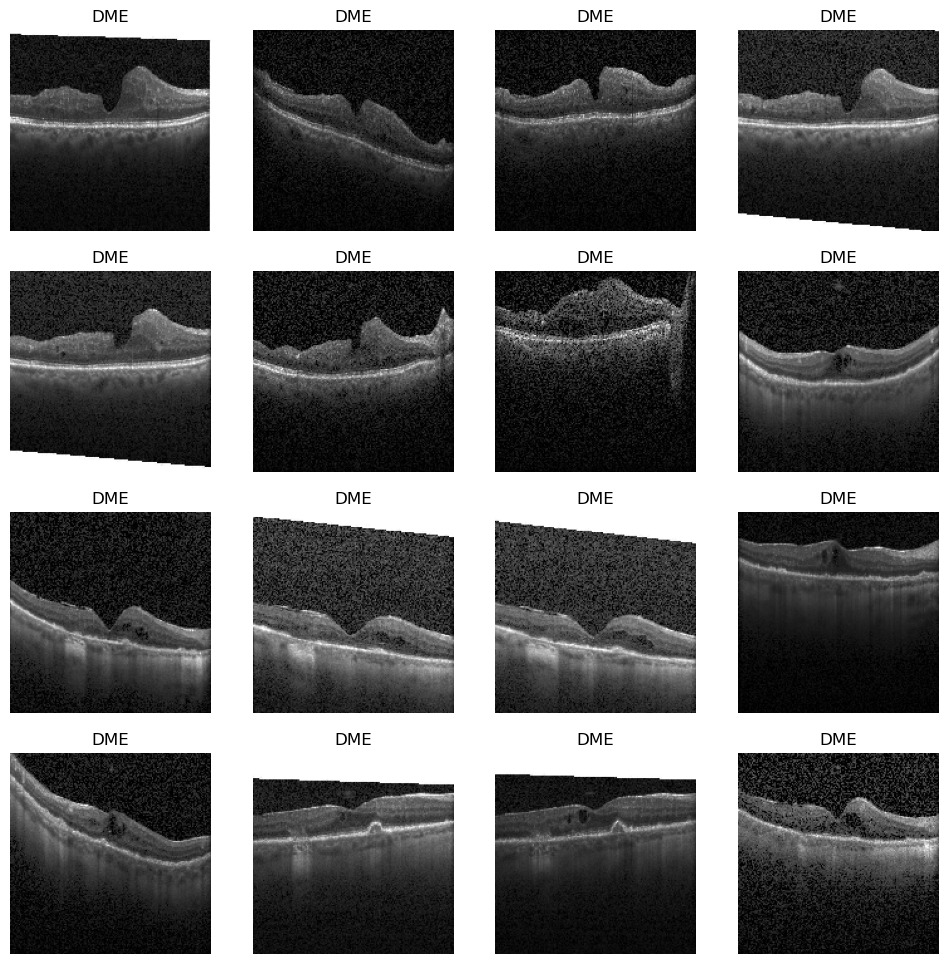

In [23]:
view_images(val_data)

In [24]:
from tensorflow.keras.applications import VGG16
vgg_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (160,160, 3))
for layer in vgg_base.layers:
    layer.trainable = False
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [25]:
vgg_model = Sequential([
    tf.keras.Input(shape = (160,160,3)),
    vgg_base,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dense(1,activation = 'sigmoid')
])
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 batch_normalization_1 (Batc  (None, 5, 5, 512)        2048      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14,848,321
Trainable params: 132,609
Non

In [26]:
vgg_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                  optimizer=Adam(learning_rate=0.0001,beta_1=0.98),
                  metrics=['accuracy']
                 )

In [27]:
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience=5,
                               mode = 'max',
                               restore_best_weights= True
                              )
lr_reduce = ReduceLROnPlateau(monitor = 'val_accuracy',
                              patience = 1,
                              min_lr=1e-6,
                              factor=0.5
                             )

In [28]:
history_vgg = vgg_model.fit(train_data, epochs=50, validation_data= val_data, callbacks=[early_stopping, lr_reduce], verbose=2)

Epoch 1/50
377/377 - 106s - loss: 0.3311 - accuracy: 0.8186 - val_loss: 0.3629 - val_accuracy: 0.8488 - lr: 1.0000e-04 - 106s/epoch - 281ms/step
Epoch 2/50
377/377 - 97s - loss: 0.4902 - accuracy: 0.8486 - val_loss: 0.6893 - val_accuracy: 0.8488 - lr: 1.0000e-04 - 97s/epoch - 258ms/step
Epoch 3/50
377/377 - 99s - loss: 0.8481 - accuracy: 0.8486 - val_loss: 1.0242 - val_accuracy: 0.8488 - lr: 5.0000e-05 - 99s/epoch - 262ms/step
Epoch 4/50
377/377 - 98s - loss: 1.1206 - accuracy: 0.8486 - val_loss: 1.2181 - val_accuracy: 0.8488 - lr: 2.5000e-05 - 98s/epoch - 261ms/step
Epoch 5/50
377/377 - 100s - loss: 1.2663 - accuracy: 0.8486 - val_loss: 1.3137 - val_accuracy: 0.8488 - lr: 1.2500e-05 - 100s/epoch - 265ms/step
Epoch 6/50
377/377 - 101s - loss: 1.3367 - accuracy: 0.8486 - val_loss: 1.3594 - val_accuracy: 0.8488 - lr: 6.2500e-06 - 101s/epoch - 267ms/step


In [29]:
from tensorflow.keras.applications import DenseNet201
dens_base = DenseNet201(weights = 'imagenet', include_top = False, input_shape = (224,224,3))
for layer in dens_base.layers[:-42]:
    layer.trainable = False
dens_base.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [30]:
from tensorflow.keras import regularizers
dens_model = Sequential([
    tf.keras.Input(shape = (224,224,3)),
    dens_base,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(1,activation = 'sigmoid')
])
dens_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 1920)       7680      
 hNormalization)                                                 
                                                                 
 global_average_pooling2d_2   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 512)               983552    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [31]:
dens_model.compile(loss = tf.keras.losses.categorical_crossentropy,
                  optimizer=Adam(learning_rate=0.0001, beta_1=0.98),
                  metrics=['accuracy']
                 )

In [32]:
dens_history= dens_model.fit(train_data, epochs=50, validation_data= val_data, callbacks=[early_stopping, lr_reduce], verbose=2)

Epoch 1/50
377/377 - 126s - loss: 0.8190 - accuracy: 0.8425 - val_loss: 1.1361 - val_accuracy: 0.8488 - lr: 1.0000e-04 - 126s/epoch - 335ms/step
Epoch 2/50
377/377 - 103s - loss: 2.1971 - accuracy: 0.8486 - val_loss: 3.7562 - val_accuracy: 0.8488 - lr: 1.0000e-04 - 103s/epoch - 273ms/step
Epoch 3/50
377/377 - 103s - loss: 4.8794 - accuracy: 0.8486 - val_loss: 6.0860 - val_accuracy: 0.8488 - lr: 5.0000e-05 - 103s/epoch - 274ms/step
Epoch 4/50
377/377 - 105s - loss: 6.7298 - accuracy: 0.8486 - val_loss: 7.3794 - val_accuracy: 0.8488 - lr: 2.5000e-05 - 105s/epoch - 277ms/step
Epoch 5/50
377/377 - 102s - loss: 7.7006 - accuracy: 0.8486 - val_loss: 8.0188 - val_accuracy: 0.8488 - lr: 1.2500e-05 - 102s/epoch - 271ms/step
Epoch 6/50
377/377 - 104s - loss: 8.1738 - accuracy: 0.8486 - val_loss: 8.3283 - val_accuracy: 0.8488 - lr: 6.2500e-06 - 104s/epoch - 275ms/step
